In [73]:
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 50)
import os
import requests
import re
from nltk import FreqDist
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from cltk.stops.grc import STOPS as stopwords
from gensim.corpora import Dictionary
import unicodedata
import json
import google_conf
import matplotlib.pyplot as plt

In [96]:
# global parameters for plots
plt.style.use("seaborn-v0_8-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams['font.size'] = 8

def save_figure(fig, fig_name):
    #each figure to be saved in four different versions
    fig.savefig("../figures/" + fig_name + ".tiff")
    fig.savefig("../figures/" + fig_name + ".png")

In [34]:
# point out to your google service account and a google sheet URL to which you wish to send your data
theos_data = google_conf.setup(sheet_url="https://docs.google.com/spreadsheets/d/19gfECdrg5rDiU2PhNYL1nKifeKzemCfYtYrAHQX5vXE/edit?usp=sharing", service_account_path="../../ServiceAccountsKey.json")

In [4]:
# find local version of the input dataset
local_paths = !find ~/Projects -name "LAGT_v3-0.parquet"
print(local_paths)

['/Users/vojtechkase/Projects/LAGT/data/large_files/LAGT_v3-0.parquet']


In [5]:
# load LAGT (v2.0) dataset locally or download it directly from Zenodo
try:
    LAGT = pd.read_parquet(local_paths[0])
except:
    pass
    #resp = requests.get("https://zenodo.org/record/7221150/files/LAGT_v2-0.json?download=1")
    # save it for next time
    #LAGT = pd.DataFrame(resp.json())
    #os.mkdir("../data/large_data/")
    #LAGT.to_json("../data/large_data/LIRE_v2-0.json")

# Short demonstration of the LAGT dataset...

In [6]:
# download and display first 5 rows of the dataset
#LAGT = pd.read_json("https://zenodo.org/record/7221150/files/LAGT_v2-0.json?download=1")
LAGT.head(5)

,author_id,doc_id,filename,author,title,string,wordcount,source,lemmatized_sentences,lemmata_source,tlg_date,not_before,not_after,date_uncertain,tlg_epithet,provenience,lemmatacount
2,ogl0001,ogl0001.ogl001,ogl0001.ogl001.1st1K-grc1.xml,Pinytus,De Epistola Pinyti ad Dionysium,"FRAGMENTUM BEATI PINYTI, CNOSSI IN CRETA EPISC...",180,1Kgr,"[[Πινυτός, ἀντιγράφω, θαυμάζω, ἀποδέχω, Διονύσ...",grecy,None,101.0,200.0,None,[],christian,34
8,tlg0005,tlg0005.tlg003,tlg0005.tlg003.1st1K-grc1.xml,Theocritus,Syrinx,Οὐδενὸς εὐνάτειρα Μακροπτολέμοιο δὲ μάτηρ μαί...,77,1Kgr,"[[οὐδενός, εὐνητήρ], [μακροπτολέμοιο, μήτηρ, μ...",grecy,4-3 B.C.,-400.0,-201.0,False,[Bucolici],pagan,61
9,tlg0006,tlg0006.tlg020,tlg0006.tlg020.1st1K-grc1.xml,Euripides,Fragmenta,ποίαν σε φῶμεν γαῖαν ἐκλελοιπότα πόλει ξενοῦσθ...,17708,1Kgr,"[[φημί, γῆ, ἐκλείπω, πόλις, ξενοῦσθαι], [πάτρα...",grecy,5 B.C.,-500.0,-401.0,False,[Tragici],pagan,10277
10,tlg0007,tlg0007.tlg146,tlg0007.tlg146.1st1K-grc1.xml,Plutarch,Παροιμίαι αἷς Ἀλεξανδρεῖς ἐχρῶντο,Οἴκοι τὰ Μιλήσια: ἐπὶ τῶν ὅποι μὴ προςήκει τὴν...,2685,1Kgr,"[[Μιλήσιος], [προςήκω, τρυφή, ἐπιδείκνυμι], [Ἀ...",grecy,A.D. 1-2,1.0,200.0,False,"[Biographi, Philosophici/-ae]",pagan,1488
11,tlg0007,tlg0007.tlg147,tlg0007.tlg147.1st1K-grc1.xml,Plutarch,Ἐκλογὴ περὶ τῶν ἀδυνάτων,Κατὰ πετρῶν σπείρεις. Πλίνθον πλύνεις. Δικτύῳ ...,143,1Kgr,"[[πέτρα, σπείρω], [Πλίνθος, πλύνω, Δίκτυον, ἄν...",grecy,A.D. 1-2,1.0,200.0,False,"[Biographi, Philosophici/-ae]",pagan,125


In [7]:
len(LAGT)

1710

In [8]:
LAGT["author_id"].nunique()

325

In [9]:

LAGT["wordcount"].sum()

32323612

In [10]:
LAGT[LAGT["author_id"].str.startswith("tlg0031")]

,author_id,doc_id,filename,author,title,string,wordcount,source,lemmatized_sentences,lemmata_source,tlg_date,not_before,not_after,date_uncertain,tlg_epithet,provenience,lemmatacount
1525,tlg0031a,tlg0031.tlg001,tlg0031.tlg001.perseus-grc2.xml,None,New Testament - Matthew,ΒΙΒΛΟΣ γενέσεως Ἰησοῦ Χριστοῦ υἱοῦ Δαυεὶδ υἱ...,18288,perseus,"[[βίβλος, γένεσις, Ἰησοῦς, Χριστός, υἱός, Δαυί...",morphgnt,A.D. 1,1.0,100.0,False,[],christian,8699
1526,tlg0031b,tlg0031.tlg002,tlg0031.tlg002.perseus-grc2.xml,None,New Testament - Mark,\n\n ΑΡΧΗ τοῦ εὐαγγελίου Ἰη...,11275,perseus,"[[ἀρχή, εὐαγγέλιον, Ἰησοῦς, Χριστός], [γράφω, ...",morphgnt,A.D. 1,1.0,100.0,False,[],christian,5308
1527,tlg0031luke,tlg0031.tlg003,tlg0031.tlg003.perseus-grc2.xml,Luke (the evangelist),New Testament - Luke,\n\n ΕΠΕΙΔΗΠΕΡ ΠΟΛΛΟΙ ἐπεχε...,19459,perseus,"[[πολύς, ἐπιχειρέω, ἀνατάσσομαι, διήγησις, πλη...",morphgnt,A.D. 1,1.0,100.0,False,[],christian,9194
1528,tlg0031john,tlg0031.tlg004,tlg0031.tlg004.perseus-grc2.xml,Johnannine literature,New Testament - John,"\n\n ΕΝ ΑΡΧΗ ἦν ὁ λόγος, κα...",15592,perseus,"[[ἀρχή, εἰμί, λόγος, λόγος, εἰμί, θεός, θεός, ...",morphgnt,A.D. 1,1.0,100.0,False,[],christian,6892
1529,tlg0031luke,tlg0031.tlg005,tlg0031.tlg005.perseus-grc2.xml,Luke (the evangelist),New Testament - Acts,\n τὸν μὲν πρῶτον λόγον ἐποιησάμην περὶ πάντων...,18405,perseus,"[[πρῶτος, λόγος, ποιέω, πᾶς, Θεόφιλος, ἄρχω, Ἰ...",morphgnt,A.D. 1,1.0,100.0,False,[],christian,9141
1530,tlg0031paul,tlg0031.tlg006,tlg0031.tlg006.perseus-grc2.xml,Paul of Tarsus,New Testament - Romans,\n\n ΠΑΥΛΟΣ δοῦλος Ἰησοῦ Χρ...,7107,perseus,"[[Παῦλος, δοῦλος, Χριστός, Ἰησοῦς, κλητός, ἀπό...",morphgnt,A.D. 1,1.0,100.0,False,[],christian,3265
1531,tlg0031paul,tlg0031.tlg007,tlg0031.tlg007.perseus-grc2.xml,Paul of Tarsus,New Testament - 1 Corinthians,\n\n ΠΑΥΛΟΣ κλητὸς ἀπόστολο...,6814,perseus,"[[Παῦλος, κλητός, ἀπόστολος, Χριστός, Ἰησοῦς, ...",morphgnt,A.D. 1,1.0,100.0,False,[],christian,3292
1532,tlg0031paul,tlg0031.tlg008,tlg0031.tlg008.perseus-grc2.xml,Paul of Tarsus,New Testament - 2 Corinthians,\n\n ΠΑΥΛΟΣ ἀπόστολος Χριστ...,4470,perseus,"[[Παῦλος, ἀπόστολος, Χριστός, Ἰησοῦς, θέλημα, ...",morphgnt,A.D. 1,1.0,100.0,False,[],christian,1925
1533,tlg0031paul,tlg0031.tlg009,tlg0031.tlg009.perseus-grc2.xml,Paul of Tarsus,New Testament - Galatians,"\n\n ΠΑΥΛΟΣ ἀπόστολος, οὐκ ...",2235,perseus,"[[Παῦλος, ἀπόστολος, ἄνθρωπος, ἄνθρωπος, Ἰησοῦ...",morphgnt,A.D. 1,1.0,100.0,False,[],christian,1058
1534,tlg0031pspa,tlg0031.tlg010,tlg0031.tlg010.perseus-grc2.xml,Pauline literature,New Testament - Ephesians,\n\n ΠΑΥΛΟΣ ἀπόστολος Χριστ...,2421,perseus,"[[Παῦλος, ἀπόστολος, Χριστός, Ἰησοῦς, θέλημα, ...",morphgnt,A.D. 1,1.0,100.0,False,[],christian,1126


In [11]:
# extract a list of all lemmatized words from all lemmatized sentences
wordlist = [w for sent in [sent for work in LAGT["lemmatized_sentences"] for sent in work] for w in sent]
# count all instances of the word θεός
wordlist.count("θεός")

60033

In [12]:
# filter for texts from the fifth and fourth c. BCE
len(LAGT[(LAGT["not_before"].between(-500,-301)) | (LAGT["not_before"].between(-500,-301))])

443

In [13]:
# index for aristotle's nicomachean ethics
i = LAGT[LAGT["doc_id"]=="tlg0086.tlg010"].index[0]
LAGT.loc[i]

author_id                                                         tlg0086
doc_id                                                     tlg0086.tlg010
filename                                  tlg0086.tlg010.perseus-grc1.xml
author                                                          Aristotle
title                                                  Nicomachean Ethics
string                  πᾶσα τέχνη καὶ πᾶσα μέθοδος, ὁμοίως δὲ πρᾶξίς ...
wordcount                                                           56630
source                                                            perseus
lemmatized_sentences    [[πᾶς, τέχνη, πᾶς, μέθοδος, πρᾶξις, προαίρεσις...
lemmata_source                                                      glaux
tlg_date                                                           4 B.C.
not_before                                                         -400.0
not_after                                                          -301.0
date_uncertain                        

# Explore overall vocabulary

In [14]:
sents = [sent for work in LAGT["lemmatized_sentences"] for sent in work]

In [15]:
len(sents)

2136459

In [16]:
min_freq = 10

def get_vocab(docs, min_freq=min_freq):
    words_flat = [item for sublist in docs for item in sublist]
    word_freq_tups = FreqDist(words_flat).most_common()
    vocabulary = [tup[0] for tup in word_freq_tups if tup[1] >= min_freq]
    #vocab_freqs = [len([doc for doc in docs if word in doc]) for word in vocabulary]
    return word_freq_tups, words_flat, vocabulary

In [17]:
word_freqs, words, vocabulary = get_vocab(sents)

In [18]:
pd.DataFrame(word_freqs[:20], columns=["lemma", "count"])

,lemma,count
0,οὗτος,329550
1,λέγω,239805
2,εἰμί,228068
3,αὐτός,213863
4,γίγνομαι,157466
5,ἔχω,146946
6,πολύς,121226
7,πᾶς,104593
8,φημί,99994
9,ἄλλος,96970


# Generate ngrams

In [19]:
doc_ids = LAGT["doc_id"].tolist()
len(doc_ids)

1710

In [20]:
#!mkdir ../data/large_data

In [21]:
line = 0
ids_lines = {}

f = open("../data/large_data/corpus_ngrams_bydocid_wide.txt", "w", encoding="utf-8")
for doc_id in doc_ids:
    lagt_subset = LAGT[LAGT["doc_id"]==doc_id]
    sents = [sen for work in lagt_subset["lemmatized_sentences"] for sen in work]
    sents_trigrams = [list(el) for sublist in [[ng for ng in nltk.trigrams(sent)] for sent in sents] for el in sublist]
    sents_fivegrams = [list(el) for sublist in [[ng for ng in nltk.ngrams(sent, n=5)] for sent in sents] for el in sublist]
    ngrams_data = sents + sents_fivegrams # + sents_trigrams
    ngrams_data = [" ".join(ngram) for ngram in ngrams_data]
    f.writelines("\n".join(ngrams_data)+"\n")
    if bool(ngrams_data):
        ids_lines[doc_id] = (line, line+len(ngrams_data))
        line += len(ngrams_data)
    else:
        ids_lines[doc_id] = (line, line+1)
        line += 1

In [22]:
pickle.dump(ids_lines, open("../data/ids_lines_wide.pickle", "wb"))

# Ngram example

In [23]:
# index for aristotle's nicomachean ethics
i = LAGT[LAGT["doc_id"]=="tlg0086.tlg010"].index[0]

In [24]:
i

'1736'

In [25]:
LAGT.loc[i]["string"].split("·")[0]

'πᾶσα τέχνη καὶ πᾶσα μέθοδος, ὁμοίως δὲ πρᾶξίς τε καὶ προαίρεσις, ἀγαθοῦ τινὸς ἐφίεσθαι δοκεῖ'

In [26]:
sent = LAGT.loc[i]["lemmatized_sentences"][0]
print(sent)

['πᾶς' 'τέχνη' 'πᾶς' 'μέθοδος' 'πρᾶξις' 'προαίρεσις' 'ἀγαθός' 'τις'
 'ἐφίημι' 'δοκέω']


In [27]:
trigrams = [list(ng) for ng in nltk.trigrams(sent)]
fivegrams = [list(ng) for ng in nltk.ngrams(sent, n=5)]
print([sent] + trigrams + fivegrams)

[array(['πᾶς', 'τέχνη', 'πᾶς', 'μέθοδος', 'πρᾶξις', 'προαίρεσις', 'ἀγαθός',
       'τις', 'ἐφίημι', 'δοκέω'], dtype=object), ['πᾶς', 'τέχνη', 'πᾶς'], ['τέχνη', 'πᾶς', 'μέθοδος'], ['πᾶς', 'μέθοδος', 'πρᾶξις'], ['μέθοδος', 'πρᾶξις', 'προαίρεσις'], ['πρᾶξις', 'προαίρεσις', 'ἀγαθός'], ['προαίρεσις', 'ἀγαθός', 'τις'], ['ἀγαθός', 'τις', 'ἐφίημι'], ['τις', 'ἐφίημι', 'δοκέω'], ['πᾶς', 'τέχνη', 'πᾶς', 'μέθοδος', 'πρᾶξις'], ['τέχνη', 'πᾶς', 'μέθοδος', 'πρᾶξις', 'προαίρεσις'], ['πᾶς', 'μέθοδος', 'πρᾶξις', 'προαίρεσις', 'ἀγαθός'], ['μέθοδος', 'πρᾶξις', 'προαίρεσις', 'ἀγαθός', 'τις'], ['πρᾶξις', 'προαίρεσις', 'ἀγαθός', 'τις', 'ἐφίημι'], ['προαίρεσις', 'ἀγαθός', 'τις', 'ἐφίημι', 'δοκέω']]


# Exploring subcorpora

In [28]:
periods = {
    "archaic" : (-800, -501),
    "classical" : (-500,-301),
    "hellenistic" : (-300,-1),
    "roman_peak" : (1, 200),
    "roman_late" : (201, 400)
}   

def get_periods(row):
    not_before = row["not_before"]
    not_after = row["not_after"]
    periods_covered = []
    try:
        for period_key in periods.keys():
            period = periods[period_key]
            if period[1] >= not_before and not_after >= period[0]:
                periods_covered.append(period_key)
    except:
        pass
    return periods_covered

In [29]:
LAGT["periods"] = LAGT.apply(get_periods, axis=1)

In [60]:
subcorpora_overview = []
for period_key in periods.keys():
    LAGT_subset = LAGT[LAGT["periods"].apply(lambda x: period_key in x)]
    subcorpora_overview.append(
        {"period" : period_key,
         "works_n" : len(LAGT_subset),
         "tokens_n" : LAGT_subset["wordcount"].sum(),
         "lemmata_n" : LAGT_subset["lemmatacount"].sum()
         }
    )
        

In [61]:
subcorpora_overview_df = pd.DataFrame(subcorpora_overview)
subcorpora_overview_df

,period,works_n,tokens_n,lemmata_n
0,archaic,59,338991,199044
1,classical,458,4133038,2046546
2,hellenistic,238,4164793,1885985
3,roman_peak,752,14202575,6260759
4,roman_late,326,9294681,3523906


In [62]:
google_conf.set_with_dataframe(theos_data.add_worksheet("subcorpora_overview", 1,1), subcorpora_overview_df)
subcorpora_overview_df.to_csv("../data/subcorpora_overview_df.csv", index=False)

In [63]:
provenience_overview_df = LAGT.groupby("provenience").agg(
    works_n=('provenience', 'size'),
    tokens_n=('wordcount', 'sum'),
    lemmata_n=('lemmatacount', 'sum')
)
provenience_overview_df

,works_n,tokens_n,lemmata_n
provenience,,,
christian,207,7574364,3055623
jewish,92,2103563,811241
pagan,1345,20366621,9270260


In [64]:
google_conf.set_with_dataframe(theos_data.add_worksheet("provenience_overview", 1,1), provenience_overview_df.reset_index())
provenience_overview_df.to_csv("../data/subcorpora_overview_df.csv")

### Overview by century

In [65]:
centuries = [(str(int(n / -100)) + "BC",  n, n+ 99) for n in range(-800, 0, 100)] + [(str(int(n / 100)) + "CE",  n - 99, n) for n in range(100, 700, 100)]
centuries

[('8BC', -800, -701),
 ('7BC', -700, -601),
 ('6BC', -600, -501),
 ('5BC', -500, -401),
 ('4BC', -400, -301),
 ('3BC', -300, -201),
 ('2BC', -200, -101),
 ('1BC', -100, -1),
 ('1CE', 1, 100),
 ('2CE', 101, 200),
 ('3CE', 201, 300),
 ('4CE', 301, 400),
 ('5CE', 401, 500),
 ('6CE', 501, 600)]

In [66]:
def get_sents(row):
    not_before = row["not_before"]
    not_after = row["not_after"]
    centuries_covered = []
    try:
        for cent in centuries:
            if cent[2] >= not_before and not_after >= cent[2]:
                centuries_covered.append(cent[0])
    except:
        pass
    return centuries_covered

In [67]:
LAGT["cents"] = LAGT.apply(get_sents, axis=1)

In [68]:
LAGT_subset = LAGT[LAGT["cents"].apply(lambda x: "8BC" in x)]
LAGT_subset

,author_id,doc_id,filename,author,title,string,wordcount,source,lemmatized_sentences,lemmata_source,tlg_date,not_before,not_after,date_uncertain,tlg_epithet,provenience,lemmatacount,periods,cents
1375,tlg0012,tlg0012.tlg001,tlg0012.tlg001.perseus-grc2.xml,Homer,Ἰλιάς,"\nμῆνιν ἄειδε θεὰ Πηληϊάδεω Ἀχιλῆος οὐλομένην,...",111895,perseus,"[[μῆνις, ἀείδω, θεά, Πηληιάδης, Ἀχιλλεύς, οὐλό...",agdt,8 B.C.,-800.0,-701.0,False,[Epici/-ae],pagan,66484,[archaic],[8BC]
1376,tlg0012,tlg0012.tlg002,tlg0012.tlg002.perseus-grc2.xml,Homer,Ὀδύσσεια,"ἄνδρα μοι ἔννεπε, μοῦσα, πολύτροπον, ὃς μάλα π...",87177,perseus,"[[ἀνήρ, ἐνέπω, Μοῦσα, πολύτροπος, πλάζω, Τροία...",agdt,8 B.C.,-800.0,-701.0,False,[Epici/-ae],pagan,50049,[archaic],[8BC]
1377,tlg0012,tlg0012.tlg003,tlg0012.tlg003.perseus-grc1.xml,Homer,Ἐπιγράμματα,"Αἰδεῖσθε ξενίων κεχρημένον ἠδὲ δόμοιο, οἳ πόλι...",772,perseus,"[[Ἕλλην, πλῆθος, Ἴλιος, στρατόω, ἑπτά, εἰμί, μ...",glaux,8 B.C.,-800.0,-701.0,False,[Epici/-ae],pagan,19,[archaic],[8BC]
1383,tlg0013,tlg0013.tlg006,tlg0013.tlg006.perseus-grc2.xml,Homeric hymn,Hymn 6 To Aphrodite,"αἰδοίην, χρυσοστέφανον, καλὴν Ἀφροδίτην ᾁσομα...",131,perseus,"[[αἰδοῖος, χρυσοστέφανος, καλός, Ἀφροδίτη, ἀεί...",glaux,8-6 B.C.,-800.0,-601.0,False,[],pagan,91,[archaic],"[8BC, 7BC]"
1385,tlg0013,tlg0013.tlg008,tlg0013.tlg008.perseus-grc2.xml,Homeric hymn,Hymn 8 To Ares,"Ἆρες ὑπερμενέτα, βρισάρματε, χρυσεοπήληξ, ὀβρ...",100,perseus,"[[Ἄρης, ὑπερμενέτης, βρισάρματε, χρυσεοπήληξ],...",grecy,8-6 B.C.,-800.0,-601.0,False,[],pagan,80,[archaic],"[8BC, 7BC]"
1386,tlg0013,tlg0013.tlg009,tlg0013.tlg009.perseus-grc2.xml,Homeric hymn,Hymn 9 To Artemis,"Ἄρτεμιν ὕμνει, Μοῦσα, κασιγνήτην Ἑκάτοιο. παρ...",57,perseus,"[[Ἄρτεμις, ὑμνέω, Μοῦσα, κασιγνήτη, Ἑκάτομαι],...",glaux,8-6 B.C.,-800.0,-601.0,False,[],pagan,36,[archaic],"[8BC, 7BC]"
1387,tlg0013,tlg0013.tlg010,tlg0013.tlg010.perseus-grc2.xml,Homeric hymn,Hymn 10 To Aphrodite,"κυπρογενῆ Κυθέρειαν ἀείσομαι, ἥτε βροτοῖσι με...",39,perseus,"[[Κυπρογενής, Κυθέρεια, ἀείδω, βροτός, μείλιχο...",glaux,8-6 B.C.,-800.0,-601.0,False,[],pagan,26,[archaic],"[8BC, 7BC]"
1388,tlg0013,tlg0013.tlg011,tlg0013.tlg011.perseus-grc2.xml,Homeric hymn,Hymn 11 To Athena,"Παλλάδʼ Ἀθηναίην ἐρυσίπτολιν ἄρχομʼ ἀείδειν, ...",35,perseus,"[[Παλλάς, Ἀθηναῖος, ἐρυσίπτολις, ἄρχω, ἀείδω, ...",glaux,8-6 B.C.,-800.0,-601.0,False,[],pagan,23,[archaic],"[8BC, 7BC]"
1389,tlg0013,tlg0013.tlg012,tlg0013.tlg012.perseus-grc2.xml,Homeric hymn,Hymn 12 To Hera,"Ἥρην ἀείδω χρυσόθρονον, ἣν τέκε Ῥείη, ἀθανάτω...",28,perseus,"[[Ἥρα, ἀείδω, χρυσόθρονος, τίκτω, Ῥέα, ἀθάνατο...",glaux,8-6 B.C.,-800.0,-601.0,False,[],pagan,23,[archaic],"[8BC, 7BC]"
1390,tlg0013,tlg0013.tlg013,tlg0013.tlg013.perseus-grc2.xml,Homeric hymn,Hymn 13 To Demeter,"Δημήτηρ’ ἠύκομον, σεμνὴν θεάν, ἄρχομ’ ἀείδειν,...",20,perseus,"[[Δημήτηρ, εὔκομος, σεμνός, θεά, ἄρχω, ἀείδω, ...",glaux,8-6 B.C.,-800.0,-601.0,False,[],pagan,17,[archaic],"[8BC, 7BC]"


In [69]:
centuries_overview = []
for cent in centuries:
    LAGT_subset = LAGT[LAGT["cents"].apply(lambda x: cent[0] in x)]
    centuries_overview.append(
        {"period" : cent[0],
         "works_n" : len(LAGT_subset),
         "tokens_n" : LAGT_subset["wordcount"].sum(),
         "lemmata_n" : LAGT_subset["lemmatacount"].sum()
         }
    )
centuries_overview_df = pd.DataFrame(centuries_overview)
centuries_overview_df

,period,works_n,tokens_n,lemmata_n
0,8BC,32,217857,128095
1,7BC,34,27577,17392
2,6BC,26,120990,70860
3,5BC,267,2278052,1215420
4,4BC,396,3443233,1659935
5,3BC,154,2239139,854292
6,2BC,83,1500282,531893
7,1BC,75,1851259,998796
8,1CE,301,4368778,2067647
9,2CE,643,11804027,5184119


In [82]:
centuries_overview = []
for cent in centuries:
    century_data = {}
    century_data["cent"] = cent
    for provenvience in ["pagan", "christian", "jewish"]:
        LAGT_subset = LAGT[(LAGT["cents"].apply(lambda x: cent[0] in x)) & (LAGT["provenience"]==provenvience)]
        century_data[provenvience + "_tokens_n"] = LAGT_subset["wordcount"].sum()
        century_data[provenvience + "_lemmata_n"] = LAGT_subset["lemmatacount"].sum()
    centuries_overview.append(century_data)
centuries_overview_df = pd.DataFrame(centuries_overview)
centuries_overview_df

,cent,pagan_tokens_n,pagan_lemmata_n,christian_tokens_n,christian_lemmata_n,jewish_tokens_n,jewish_lemmata_n
0,"(8BC, -800, -701)",217857,128095,0,0,0,0
1,"(7BC, -700, -601)",27577,17392,0,0,0,0
2,"(6BC, -600, -501)",120990,70860,0,0,0,0
3,"(5BC, -500, -401)",2276176,1214614,0,0,0,0
4,"(4BC, -400, -301)",3441413,1659065,0,0,0,0
5,"(3BC, -300, -201)",1365275,599331,0,0,872098,254116
6,"(2BC, -200, -101)",628002,277670,0,0,872098,254116
7,"(1BC, -100, -1)",1111839,708927,0,0,737227,288757
8,"(1CE, 1, 100)",2824801,1361768,327751,155556,1212756,548700
9,"(2CE, 101, 200)",9928386,4415547,1793408,731117,0,0


In [85]:
centuries_overview_df["cent_label"] = centuries_overview_df["cent"].apply(lambda x: x[0])

In [138]:
#google_conf.set_with_dataframe(theos_data.add_worksheet("centuries_overview", 1,1), centuries_overview_df)

In [121]:
colors = ["darkblue", "darkgreen", "darkred"]
periods_colors = ['lightcyan',
                  'lightgoldenrodyellow',
                  'lightgray',
                  'lightgreen',
                  'lightpink']

In [122]:
periods_dict = { # to avoid overlaps, startdates are postponed by one year, when needed
    "archaic" : {"startdate": -0.5, "enddate" : 2.5},
    "classical" : {"startdate": 2.5, "enddate": 4.5},
    "hellenistic" : {"startdate" : 4.5, "enddate" : 7.5},
    "roman_peak" : {"startdate": 7.5, "enddate": 9.5},
    "roman_late" : {"startdate" : 9.5, "enddate" : 13.5}}

[Text(0, 0, '8BC'),
 Text(1, 0, '7BC'),
 Text(2, 0, '6BC'),
 Text(3, 0, '5BC'),
 Text(4, 0, '4BC'),
 Text(5, 0, '3BC'),
 Text(6, 0, '2BC'),
 Text(7, 0, '1BC'),
 Text(8, 0, '1CE'),
 Text(9, 0, '2CE'),
 Text(10, 0, '3CE'),
 Text(11, 0, '4CE'),
 Text(12, 0, '5CE'),
 Text(13, 0, '6CE')]

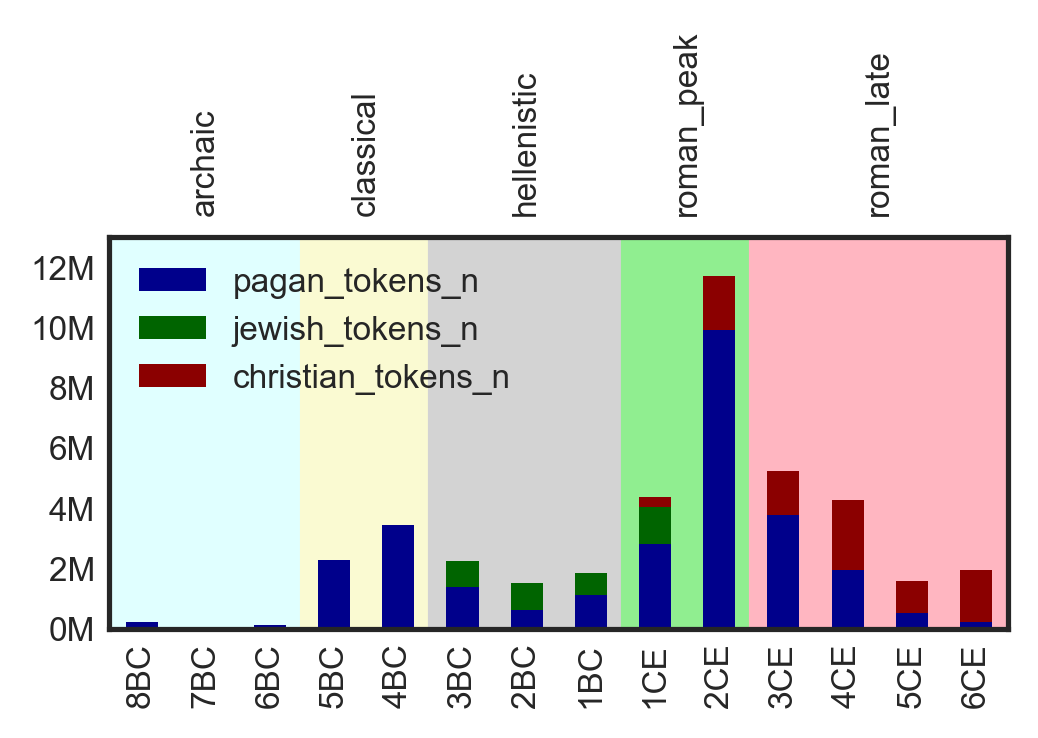

In [133]:
fig, ax = plt.subplots(figsize=(3.5,2.5), tight_layout=True)

ax.set_yticks(range(0,20000000, 2000000))
ax.set_yticklabels([str(n) + "M" for n in range(0,20, 2)])
ax.set_ylim(0,13000000)
ax.set_xlim(-1,14)

for period, color in zip(periods_dict.keys(), periods_colors):
    ax.axvspan(periods_dict[period]["startdate"], periods_dict[period]["enddate"], color=color)
    midpoint = (periods_dict[period]["startdate"] + periods_dict[period]["enddate"]) / 2  # calculate midpoint for label
    ax.annotate(period, (midpoint, ax.get_ylim()[1] * 0.95), xytext=(0, 10),
            textcoords='offset points', ha='center', va='bottom', rotation=90)

centuries_overview_df[["pagan_tokens_n", "jewish_tokens_n", "christian_tokens_n"]].plot(kind='bar', color=colors, stacked=True, ax=ax)

ax.set_xticks(range(0,14))
ax.set_xticklabels(centuries_overview_df["cent_label"])



In [135]:
save_figure(fig, "centuries_overview")

# Building vocabulary data

In [83]:
def try_to_get_from_freqdict(word, word_freqs_dict):
    total_N = sum([val for val in word_freqs_dict.values()])
    try:
        count = word_freqs_dict[word]
        freq = count #/ total_N
    except:
        freq = 0
    return freq


min_freq = 5

def get_vocab(docs, min_freq=min_freq):
    words_flat = [item for sublist in docs for item in sublist]
    total_words = len(words_flat)
    wordcounts_tups = FreqDist(words_flat).most_common()
    wordfreqs_tups = [(tup[0], tup[1] / total_words) for tup in wordcounts_tups]
    return wordcounts_tups, wordfreqs_tups

wordcounts_dicts = []
wordfreqs_dicts = []


for sub in periods.keys():
    subset = LAGT[LAGT["periods"].apply(lambda x: sub in x)]
    sents = [sent for work in subset["lemmatized_sentences"] for sent in work]
    wordcounts_tups, wordfreqs_tups = get_vocab(sents)
    wordcounts_dicts.append(dict(wordcounts_tups))
    wordfreqs_dicts.append(dict(wordfreqs_tups))

In [84]:
wordcounts_df = pd.DataFrame(wordcounts_dicts).T
wordcounts_df.columns = periods.keys()
wordcounts_df.head(5)

,archaic,classical,hellenistic,roman_peak,roman_late
εἰμί,2975.0,74864.0,37808.0,113388.0,24922.0
πᾶς,1625.0,19939.0,17267.0,42860.0,24363.0
ἀνήρ,1608.0,8559.0,5977.0,13606.0,7555.0
αὐτός,1526.0,42501.0,25916.0,129660.0,38207.0
θεός,1454.0,5594.0,9751.0,29952.0,27200.0


In [85]:
wordfreqs_df = pd.DataFrame(wordfreqs_dicts).T
wordfreqs_df.columns = periods.keys()
wordfreqs_df.head(5)

,archaic,classical,hellenistic,roman_peak,roman_late
εἰμί,0.015068,0.036587,0.020051,0.018114,0.007074
πᾶς,0.008230,0.009744,0.009157,0.006847,0.006915
ἀνήρ,0.008144,0.004183,0.003170,0.002174,0.002144
αὐτός,0.007729,0.020771,0.013744,0.020714,0.010844
θεός,0.007364,0.002734,0.005171,0.004785,0.007720


In [86]:
religion_final = ["θεός", "Ζεύς", "εὐσεβής", 'ἱερός']
morality_final = ["ἀγαθός", "ἀρετή", "δίκαιος", "τιμή"]

In [87]:
pd.concat([wordfreqs_df.loc[religion_final], wordfreqs_df.loc[morality_final]])

,archaic,classical,hellenistic,roman_peak,roman_late
θεός,0.007364,0.002734,0.005171,0.004785,0.007720
Ζεύς,0.006463,0.001315,0.000492,0.000736,0.000444
εὐσεβής,0.000061,0.000059,0.000066,0.000054,0.000125
ἱερός,0.000669,0.000540,0.000795,0.000595,0.000323
ἀγαθός,0.001286,0.004563,0.002314,0.003010,0.003137
ἀρετή,0.000537,0.001141,0.001219,0.000869,0.000934
δίκαιος,0.000405,0.001734,0.000850,0.000767,0.001091
τιμή,0.000664,0.000429,0.000537,0.000455,0.000434


In [114]:
pd.concat([wordcounts_df.loc[religion_final], wordcounts_df.loc[morality_final]])

,archaic,classical,hellenistic,roman_peak,roman_late
θεός,1454.0,5594.0,9751.0,29952.0,27200.0
Ζεύς,1276.0,2690.0,928.0,4609.0,1563.0
εὐσεβής,12.0,121.0,124.0,339.0,440.0
ἱερός,132.0,1105.0,1499.0,3722.0,1139.0
ἀγαθός,254.0,9336.0,4363.0,18842.0,11051.0
ἀρετή,106.0,2334.0,2299.0,5442.0,3290.0
δίκαιος,80.0,3548.0,1603.0,4802.0,3844.0
τιμή,131.0,877.0,1012.0,2846.0,1529.0


In [95]:
len(wordcounts_df)

507365

In [113]:
wordcounts_df[(wordcounts_df >= 5).all(axis=1)].tail(10)# # .notnull().all(axis=1).sum()

,archaic,classical,hellenistic,roman_peak,roman_late
ἀπαλλαγή,5.0,84.0,72.0,210.0,178.0
ἐλευθερόω,5.0,156.0,175.0,311.0,157.0
εὔφημος,5.0,32.0,10.0,73.0,35.0
λύμη,5.0,26.0,22.0,51.0,55.0
χλιδή,5.0,20.0,7.0,32.0,22.0
μεσημβρινός,5.0,18.0,215.0,341.0,51.0
κατεύχομαι,5.0,21.0,9.0,17.0,5.0
φαιδρός,5.0,25.0,20.0,151.0,122.0
ἀποστατέω,5.0,28.0,7.0,20.0,24.0
πρεσβεύω,5.0,179.0,190.0,445.0,255.0


In [132]:
shared_vocabulary = list(wordcounts_df[(wordcounts_df >= 5).all(axis=1)].index) # .notnull().all(axis=1).sum())
len(shared_vocabulary)

3133

In [133]:
with open("../data/shared_vocabulary.pickle", "wb") as f:
    pickle.dump(shared_vocabulary, f)

In [134]:
vocabulary_mostcommon2000 = []
for key in periods.keys():
    vocabulary_mostcommon2000.extend(list(wordcounts_df.sort_values(key, ascending=False).index[:2000]))

In [135]:
len(list(set(vocabulary_mostcommon2000 + shared_vocabulary)))

5110

In [136]:
vocabulary_balanced = list(set(vocabulary_mostcommon2000 + shared_vocabulary))
with open("../data/vocabulary_balanced.pickle", "wb") as f:
    pickle.dump(vocabulary_balanced, f)

In [122]:
wordcounts_df.to_json("../data/wordcounts_df.json")
wordfreqs_df.to_json("../data/wordfreqs_df.json")

In [136]:
LAGT.to_parquet("../data/large_data/LAGT_theos.parquet")